In [2]:
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import numpy as np
import os

In [3]:
# 當前路徑
import sys
import os

current_dir = current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from image_process import SaturationMap, DarkChannel

/home/jimmy/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [4]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("cuDNN enabled:", torch.backends.cudnn.enabled)

if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPUs detected.")

torch.cuda.set_device(0) #選擇使用的GPU 0 or 1

current_device = torch.cuda.current_device()
print(f"Current GPU index: {current_device}")
print(f"Current GPU Name: {torch.cuda.get_device_name(current_device)}")

PyTorch version: 2.3.0+cu121
CUDA available: True
CUDA version: 12.1
cuDNN enabled: True
Number of GPUs available: 2
GPU 0: NVIDIA GeForce RTX 4090
GPU 1: NVIDIA GeForce RTX 4090
Current GPU index: 0
Current GPU Name: NVIDIA GeForce RTX 4090


In [5]:
# 圖像預處理
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img_tensor = preprocess(img)
    return img_tensor

def preprocess_auxiliary(image_path):
    img = Image.open(image_path).convert('RGB')
    img_np = np.array(img)
    dark = DarkChannel(img_np)
    saturation = SaturationMap(img_np)
    aux_input_tensor = torch.cat([transforms.ToTensor()(dark), transforms.ToTensor()(saturation)], dim=0) # (C, H, W)
    return aux_input_tensor
    

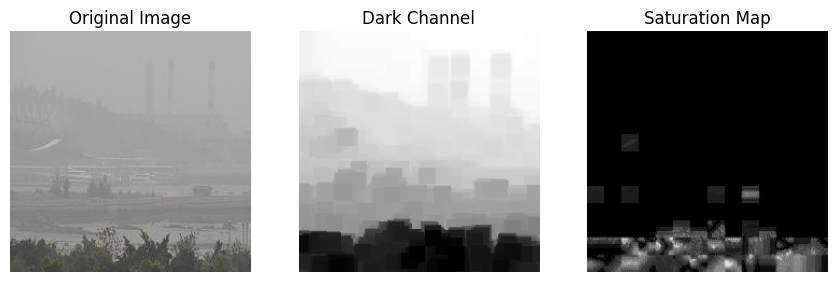

In [6]:
# 測試圖片
import matplotlib.pyplot as plt

def show_images(image_tensor, aux_input_tensor):
    # tensor to numpy，並把通道放到最尾端
    image_np = image_tensor.permute(1, 2, 0).numpy()
    aux_input_np = aux_input_tensor.permute(1, 2, 0).numpy()
    # high_low_np = high_low_tensor.permute(1, 2, 0).numpy()

    # 分離DC和saturation
    dark_channel = aux_input_np[:, :, 0]
    saturation_map = aux_input_np[:, :, 1]

    # HIGH = high_low_np[:, :, 0]
    # LOW = high_low_np[:, :, 1]
    
    # 顯示結果
    plt.figure(figsize=(18, 4))

    # 顯示原始圖像
    plt.subplot(1, 5, 1)
    plt.imshow(image_np)
    plt.title('Original Image')
    plt.axis('off')
    
    # 顯示暗通道圖像
    plt.subplot(1, 5, 2)
    plt.imshow(dark_channel, cmap='gray')
    plt.title('Dark Channel')
    plt.axis('off')
    
    # 顯示飽和度圖像
    plt.subplot(1, 5, 3)
    plt.imshow(saturation_map, cmap='gray')
    plt.title('Saturation Map')
    plt.axis('off')

    

    # # 顯示HIGH
    # plt.subplot(1, 5, 4)
    # plt.imshow(HIGH, cmap='gray')
    # plt.title('HIGH')
    # plt.axis('off')
    # # 顯示LOW
    # plt.subplot(1, 5, 5)
    # plt.imshow(LOW, cmap='gray')
    # plt.title('LOW')
    # plt.axis('off')

    # plt.show()


image = '077-202401010750.jpg'
station = '金門'
image_path = parent_dir + '/' + station + '/' + station + 'resize三合一' + '/' + image


image_tensor = preprocess_image(image_path)
aux_input_tensor = preprocess_auxiliary(image_path)
# high_low_tensor = high_low_concate(image_path, high_sigma=10, low_sigma=10)

show_images(image_tensor, aux_input_tensor)

In [7]:
class DataGenerator(Dataset):
    def __init__(self, df, image_folder, transform=None):
        self.df = df
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        image_name = row['filename']
        image_path = os.path.join(self.image_folder, image_name)
        RH_value = row['RH']
        

        if not os.path.exists(image_path):
            print(f"Warning: {image_path} does not exist. Skipping this file.")
            return torch.zeros(3, 224, 224), torch.zeros(2, 224, 224), torch.zeros(1), 0.0
            
        main_input = preprocess_image(image_path)
        aux_input = preprocess_auxiliary(image_path)
        RH_tensor = torch.tensor([RH_value], dtype=torch.float32)

        label = row['PM2.5']

        # Apply image transformations
        if self.transform:
            main_input = self.transform(main_input)
            aux_input = self.transform(aux_input)

        return (main_input, aux_input, RH_tensor), label

In [8]:
station = '金門'
kind = '三合一'  # 二合一高PM  二合一高RH  三合一  二合一高PM高RH
# csv_path = parent_dir + '/' + station + '/' + station + '_' + kind + '.csv'
image_folder = parent_dir + '/' + station + '/' + station + 'resize三合一'

In [9]:
# encodings = ['utf-8', 'big5', 'gbk']
# for encoding in encodings:
#     try:
#         df = pd.read_csv(csv_path, encoding=encoding)
#         print(f"CSV文件成功使用 {encoding} 編碼讀取。")
#         break
#     except UnicodeDecodeError:
#         print(f"讀取CSV文件時出現編碼錯誤，嘗試使用 {encoding} 編碼失敗。")
#     except Exception as e:
#         print(f"讀取CSV文件時出現錯誤: {e}")

# # 如果沒有成功讀取，提示用戶
# if 'df' not in locals():
#     print("無法使用任何嘗試的編碼讀取CSV文件。")
# else:
#     print(df.head())

In [10]:
# # 分割資料集為train, valid, test
# from sklearn.model_selection import train_test_split

# train_val_df, test_df = train_test_split(df, test_size=0.05, random_state=42)
# train_df, val_df = train_test_split(train_val_df, test_size=0.16, random_state=42) # train: 80%, valid: 15%, test: 5%

In [11]:
# train_df.to_csv(parent_dir + '/' + station + '/' + station + '_' + kind + '_train.csv', index=False)
# val_df.to_csv(parent_dir + '/' + station + '/' + station + '_' + kind + '_valid.csv', index=False)
# test_df.to_csv(parent_dir + '/' + station + '/' + station + '_' + kind + '_test.csv', index=False)

In [12]:
train_df = pd.read_csv(parent_dir + '/' + station + '/' + station + '_' + kind + '_train.csv')
val_df = pd.read_csv(parent_dir + '/' + station + '/' + station + '_' + kind + '_valid.csv')
test_df = pd.read_csv(parent_dir + '/' + station + '/' + station + '_' + kind + '_test.csv')

In [13]:
train_dataset = DataGenerator(train_df, image_folder=image_folder, transform=None)
val_dataset = DataGenerator(val_df, image_folder=image_folder, transform=None)
test_dataset = DataGenerator(test_df, image_folder=image_folder, transform=None)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [14]:
from DDPM_CNN import CompleteModel3

model = CompleteModel3()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/home/jimmy/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # cuda:1
model.to(device)

CompleteModel3(
  (main_branch): MainBranch(
    (model): SwinTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      )
      (layers): Sequential(
        (0): SwinTransformerStage(
          (downsample): Identity()
          (blocks): Sequential(
            (0): SwinTransformerBlock(
              (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attn): WindowAttention(
                (qkv): Linear(in_features=96, out_features=288, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=96, out_features=96, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
                (softmax): Softmax(dim=-1)
              )
              (drop_path1): Identity()
              (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (mlp): Mlp

In [15]:
# Learning Rate Scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.3, verbose=True) # 實例化

/home/jimmy/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [16]:
# early stopping
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint3_TEST0.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


early_stopping = EarlyStopping(patience=20, verbose=True, delta=0.001) # 實例化

In [17]:
# HS algorithm
from scipy.ndimage import gaussian_filter1d

def calculate_weights(y, bw=10, s=5, sigma=2, clip_min=5, clip_max=500):
    # 建立直方圖
    bins = np.arange(np.min(y), np.max(y) + bw, step=bw)
    # print("Minimum value of y:", np.min(y))
    # print("Maximum value of y:", np.max(y))
    hist, bin_edges = np.histogram(y, bins=bins)
    clipped_hist = np.clip(hist, clip_min, clip_max)

    # 高斯平滑
    smooth_hist = gaussian_filter1d(clipped_hist, sigma=sigma)

    # 計算每個 bin 的權重
    weights = 1 / smooth_hist
    weights /= np.sum(weights) * len(weights)  # 正規化權重

    # 將每個樣本映射到對應的權重
    sample_indices = np.digitize(y, bins=bins) - 1
    sample_indices = np.clip(sample_indices, 0, len(weights) - 1)  # 確保index不會越界
    sample_weights = weights[sample_indices]

    return torch.from_numpy(sample_weights).float()

In [18]:
num_epochs = 300
train_loss_values = []  
val_loss_values = []  # 畫圖用的

# 訓練
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # 獲取當前 epoch 的所有標籤用於計算權重
    labels_array = np.array([train_dataset.df.iloc[idx]['PM2.5'] for idx in range(len(train_dataset))])
    weights = calculate_weights(labels_array)
    
    for i, (inputs, labels) in enumerate(train_loader):
        main_inputs, aux_inputs, RH = inputs
        RH = RH.view(-1, 1)
        
        # print("Shapes:", main_inputs.shape, aux_inputs.shape, RH.shape)
        main_inputs = main_inputs.to(device).float()
        aux_inputs = aux_inputs.to(device).float()
        RH = RH.to(device).float()
        labels = labels.to(device).float()

        # 當前批次的權重
        batch_weights = weights[i * train_loader.batch_size:(i + 1) * train_loader.batch_size].to(device)
        optimizer.zero_grad()

        # 前向傳播
        outputs = model(main_inputs, aux_inputs, RH)
        outputs = outputs.squeeze()
        
        # 應用HS
        loss = torch.mean(batch_weights * (outputs - labels) ** 2) # HS用來反饋

        loss2 = criterion(outputs, labels) # MSE用來評估
        
        # 反向傳播和優化
        loss.backward()
        optimizer.step()

        running_loss += loss2.item()

    train_epoch_loss = running_loss / len(train_loader)
    train_loss_values.append(train_epoch_loss)

    # 驗證
    model.eval()
    with torch.no_grad():
        running_val_loss = 0.0
        for i, (inputs, labels) in enumerate(val_loader):
            main_inputs, aux_inputs, RH = inputs
            RH = RH.view(-1, 1)
            
            main_inputs = main_inputs.to(device).float()
            aux_inputs = aux_inputs.to(device).float()
            RH = RH.to(device).float()
            labels = labels.to(device).float()

            outputs = model(main_inputs, aux_inputs, RH)
            outputs = outputs.squeeze()
            val_loss = criterion(outputs, labels) # MSE用來評估

            running_val_loss += val_loss.item()

        val_epoch_loss = running_val_loss / len(val_loader)
        val_loss_values.append(val_epoch_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}")

    
    # Early Stopping
    early_stopping(val_epoch_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    # Learning Rate Scheduler
    scheduler.step(val_epoch_loss)

/home/jimmy/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/300], Train Loss: 368.1433, Validation Loss: 360.9129
Validation loss decreased (inf --> 360.912898).  Saving model ...
Epoch [2/300], Train Loss: 333.6436, Validation Loss: 293.8006
Validation loss decreased (360.912898 --> 293.800620).  Saving model ...
Epoch [3/300], Train Loss: 313.4773, Validation Loss: 250.0042
Validation loss decreased (293.800620 --> 250.004237).  Saving model ...
Epoch [4/300], Train Loss: 334.1805, Validation Loss: 287.1401
EarlyStopping counter: 1 out of 20
Epoch [5/300], Train Loss: 315.4150, Validation Loss: 286.4142
EarlyStopping counter: 2 out of 20
Epoch [6/300], Train Loss: 321.6741, Validation Loss: 271.0766
EarlyStopping counter: 3 out of 20
Epoch [7/300], Train Loss: 297.3127, Validation Loss: 284.1042
EarlyStopping counter: 4 out of 20
Epoch [8/300], Train Loss: 293.6571, Validation Loss: 274.9524
EarlyStopping counter: 5 out of 20
Epoch [9/300], Train Loss: 303.9478, Validation Loss: 263.6867
EarlyStopping counter: 6 out of 20
Epoch [10/3

KeyboardInterrupt: 

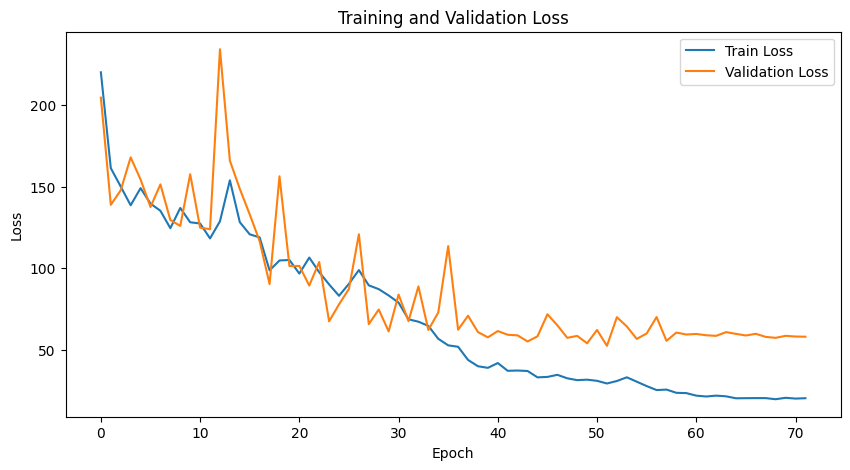

In [19]:
#畫圖
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_loss_values, label='Train Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [20]:
# 保存模型
torch.save(model.state_dict(), 'TEST_TORCH3_' + station + '_' + kind + '.pth')
print("Model saved as model.pth")

Model saved as model.pth


In [21]:
# 評估模型
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, kendalltau
import numpy as np

model.eval()

actuals = []
predictions = []

# 無梯度推理
with torch.no_grad():
    for inputs, labels in test_loader:
        main_inputs, aux_inputs, RH = inputs
        main_inputs = main_inputs.to(device).float()
        aux_inputs = aux_inputs.to(device).float()
        RH = RH.to(device).float()
        labels = labels.to(device).float()

        outputs = model(main_inputs, aux_inputs, RH)
        outputs = outputs.squeeze()

        outputs = outputs.cpu().numpy()
        if outputs.ndim == 0:  # 如果 outputs 是一个标量
            outputs = np.expand_dims(outputs, 0)

        # 結果
        actuals.extend(labels.tolist())
        predictions.extend(outputs.tolist())


actuals = np.array(actuals)
predictions = np.array(predictions)

In [22]:
# RMSE
rmse = np.sqrt(mean_squared_error(actuals, predictions))
print(f"RMSE: {rmse}")

RMSE: 7.69354421846919


In [23]:
# MAE
mae = mean_absolute_error(actuals, predictions)
print(f"MAE: {mae}")

MAE: 6.032684778555845


In [24]:
# NMGE
epsilon = 1e-8
nmge = np.mean(np.abs((actuals - predictions) / (actuals + epsilon)))
print(f"NMGE: {nmge}")

NMGE: 0.759367628020064


In [25]:
# LCC
lcc = pearsonr(actuals, predictions)[0]
print(f"LCC: {lcc}")

LCC: 0.8400877425634841


In [26]:
# KRC
krc = kendalltau(actuals, predictions)[0]
print(f"KRC: {krc}")

KRC: 0.6003721273205793


In [28]:
#測試
df_test = pd.read_csv(parent_dir + '/' + station + '/' + station + '_三合一.csv')
test_image = "047-20190110172443.jpg"

row = df_test[df_test['filename'] == test_image]
image_path = parent_dir + "/" + station + "/" + station + "resize三合一/" + test_image

image_tensor = preprocess_image(image_path)
aux_input_tensor = preprocess_auxiliary(image_path)

if not row.empty:
    pm_value = row['PM2.5'].iloc[0]
    rh_value = row['RH'].iloc[0]
    print(f"The PM2.5 value for {test_image} is: {pm_value}")
    print(f"The RH value for {test_image} is: {rh_value}")
else:
    print(f"No data found for {test_image}")

# print(image_path)

The PM2.5 value for 047-20190110172443.jpg is: 50.0
The RH value for 047-20190110172443.jpg is: 69.0


In [29]:
image_tensor = image_tensor.to(device).float()
aux_input_tensor = aux_input_tensor.to(device).float()
rh_tensor = torch.tensor([rh_value], dtype=torch.float32, device=device)

In [30]:
with torch.no_grad():
    output = model(image_tensor.unsqueeze(0), aux_input_tensor.unsqueeze(0), rh_tensor)
    pm25_concentration = output.item()

print(f"Estimated PM2.5 concentration: {pm25_concentration:.4f}")

Estimated PM2.5 concentration: 38.6208
